# Strengths of currents

The notebook calculates the strength of the California Current and California Undercurrent for a domain similar to "A climatology of the California CurrentSystem from a network of underwater gliders" (Rudnick, 2017). The following figures are created in this notebook:
- Figure A.9 California Current and Undercurrent strength

In [1]:
import sys
sys.path.append('/nfs/kryo/work/maxsimon/master-thesis/scripts/')

import os
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from romstools.romsrun import RomsRun
from romstools.plot import plot_data
from romstools.utils import p, cache, np_rolling_mean
from romstools.cmap import DIFF, DIFF_r, W2G, W2G_r, G2R, G2R_r, get_step_cmap
from romstools.dataset import open_dataset

import scipy.signal as sig
import scipy.stats as stat

import cartopy.crs as ccrs

import warnings
from datetime import timedelta as tdelta

import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.cm import get_cmap

## Load Data

In [2]:
### pactcs30
meso = RomsRun('/nfs/kryo/work/maxsimon/data/pactcs30/grid.nc')
# add location of zlevels
meso.add_data('/nfs/kryo/work/maxsimon/data/pactcs30/z/z_levels.nc')
# add horizontal velocities
meso.add_data('/nfs/kryo/work/maxsimon/data/pactcs30/climatologies/z_vel-1d.nc')
# add density
meso.add_data('/nfs/kryo/work/maxsimon/data/pactcs30/climatologies/z_data-1d.nc')
# add additional grid data
data = np.load('/nfs/kryo/work/maxsimon/data/pactcs30/grid.npz', allow_pickle=True)
meso.distance_map = data['distance_map']
meso.distance_lines = data['distance_lines']
meso.gruber_mask = data['gruber_mask']

### pactcs15
subm = RomsRun('/nfs/kryo/work/maxsimon/data/pactcs15/grid.nc')
# add location of zlevels
subm.add_data('/nfs/kryo/work/maxsimon/data/pactcs15/z/z_levels.nc')
# add horizontal velocities
subm.add_data('/nfs/kryo/work/maxsimon/data/pactcs15/climatologies/z_vel-1d.nc')
# add density
subm.add_data('/nfs/kryo/work/maxsimon/data/pactcs15/climatologies/z_data-1d.nc')
# add additional grid data
data = np.load('/nfs/kryo/work/maxsimon/data/pactcs15/grid.npz', allow_pickle=True)
subm.distance_map = data['distance_map']
subm.distance_lines = data['distance_lines']
subm.gruber_mask = data['gruber_mask']

In [3]:
runs = {
    'pactcs15': subm,
    'pactcs30': meso
}

## Subdomain

The subdomain is defined such that it corresponds to
> Rudnick, Daniel L. et al. (May 2017). “A climatology of the California CurrentSystem from a network of underwater gliders.”, Figure 4.2.3.1

In [4]:
SLICE_SUBM_1 = (slice(None, None), slice(640, 720))
SLICE_MESO_1 = (slice(None, None), slice(261, 296))

vertical_sections = {
    'pactcs30': SLICE_MESO_1,
    'pactcs15': SLICE_SUBM_1
}

/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:123: RuntimeWarning: invalid value encountered in greater
  data_main[data_main > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:124: RuntimeWarning: invalid value encountered in less
  data_main[data_main < vmin] = vmin
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:128: RuntimeWarning: invalid value encountered in greater
  data_subd[data_subd > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:129: RuntimeWarning: invalid value encountered in less
  data_subd[data_subd < vmin] = vmin


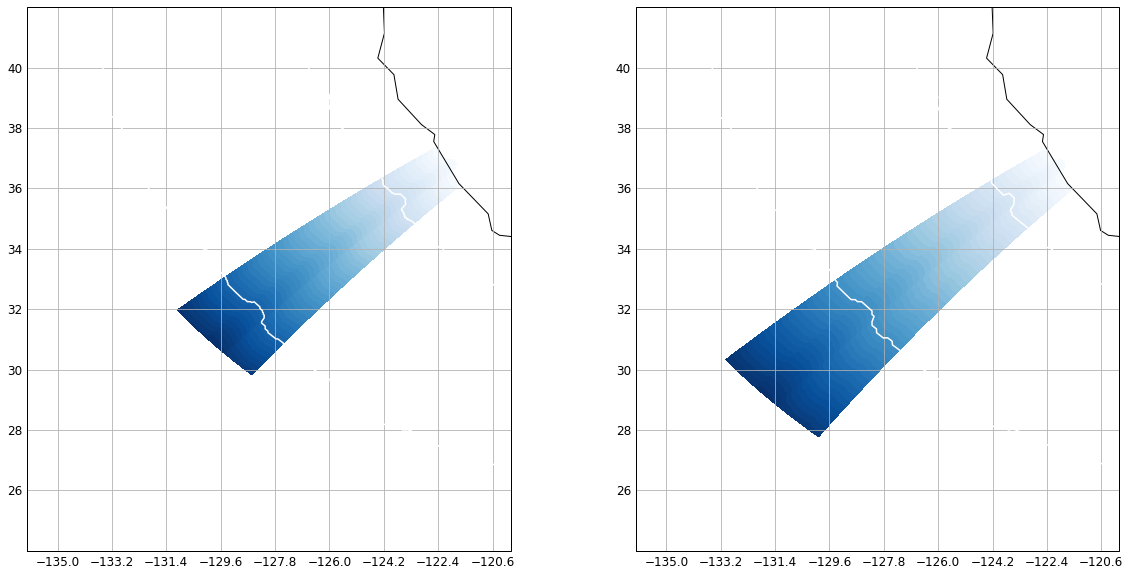

In [5]:
# Plot subdomain

def plot_run_slices(run, ax, slices):    
    for s in slices:
        plot_data(run.grid, run.distance_map, ax=ax, highlight_subdomain=s, lon_name='lon_rho', lat_name='lat_rho', as_contourfill=True, cbar_label='Distance [km]', cmap='Blues', highlight_subdomain_alpha=0.0, colorbar=False);
    for line in run.distance_lines:
        ax.plot(line[0], line[1], color='white', transform=ccrs.PlateCarree())
    ax.set_ylim(24, 42)
    ax.set_xlim(-136, -120)

    
fig, ax = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

plot_run_slices(subm, ax[0], [SLICE_SUBM_1])
plot_run_slices(meso, ax[1], [SLICE_MESO_1])

plt.show()

## Plotting and interpolation

In [6]:
# see eddy_quenching for an analysis of this
interp_points = {
    'pactcs15': 200,
    'pactcs30': 100
}

In [7]:
## This is a copy from eddy_quenching.
## TODO: move to external module

def fix_nan_contour(func, distance_map, depth_values, data, **kwargs):
    # matplotlibs contour plots can not handle NaNs
    # this function fixes this
    xx, yy = None, None
    if len(distance_map.shape) == 2:
        print('WARNING :: DISTANCE MAP ON SECTION SLICE?')
        contour_x = np.mean(distance_map, axis=1)
        x_1 = np.argmin(np.isnan(contour_x[::-1]))
        xx, yy = np.meshgrid(contour_x[:-x_1], -depth_values)
    else:
        contour_x = distance_map
        xx, yy = np.meshgrid(contour_x, -depth_values)
    return func(xx[:data.shape[0]], yy[:data.shape[0]], data, **kwargs)


def interpolate_to_dist(data, name, num_interp_points, distance_map=None):
    # interpolate data on rho grid to a grid with distance to coast as the main axis.
    
    # get run and distance map
    run = runs[name]
    dmap = run.distance_map[vertical_sections[name]] if distance_map is None else distance_map
    
    # set up bins
    distances = np.linspace(0, 900, num_interp_points)
    # and result array
    result = np.empty((data.shape[0], distances.shape[0] - 1))
    centers = []
    
    # loop bins
    for dist_idx in range(distances.shape[0] - 1):
        # create mask
        mask = np.logical_and(
            dmap >= distances[dist_idx],
            dmap < distances[dist_idx + 1]
        )
        # calculate the value as average over all points belonging to the bin
        value = np.nanmean(
            data[:, mask], axis=1
        )
        # assign value to result
        result[:, dist_idx] = value
        # save the bin center for x coordinates
        centers.append(distances[dist_idx] + (distances[dist_idx + 1] - distances[dist_idx])/2)
    
    return np.array(centers), result

In [8]:
def plot_vertical(self, ax, distances, values, vmin=None, vmax=None, num_levels=30, num_levels_lines=10, cmap=None, colorbar_label='', contour_lines=None, colorbar=True):
    # set limits
    ax.set_xlim(900, 0)
    
    # use number of levels or contstruct levels from vmin and vmax
    levels = num_levels if vmin is None or vmax is None else np.linspace(vmin, vmax, num_levels)
    # plot data
    cax = fix_nan_contour(ax.contourf, distances, self.z_level, values, levels=levels, vmin=vmin, vmax=vmax, cmap=cmap, extend='both')
    # get data for contours
    contour_values = contour_lines if contour_lines is not None else values
    # plot contours
    if num_levels_lines > 0:
        cax2 = fix_nan_contour(ax.contour, distances, self.z_level, contour_values, levels=num_levels_lines, colors='k', extend='both')
        ax.clabel(cax2, cax2.levels, inline=True, fontsize=10)
    
    # labels
    ax.set_xlabel('Distance to coast [km]')
    ax.set_ylabel('Depth [m]')
    
    # colorbar
    ticks = None  # if vmin and vmax is provided, set up ticks for colorbar manually
    if vmin is not None and vmax is not None:
        ticks = np.linspace(vmin, vmax, 11)
    
    if colorbar:
        plt.colorbar(cax, ticks=ticks, label=colorbar_label, ax=ax)
        
    return cax

## Calculate Velocity

In [9]:
def calc_u_vertical(self, section_slice, time_slice, name, var_contour='u_b'):
    """
    Calculate a vertical section of u (parrallel to coast) for a given xi-section and time slice
    """
    
    num_interp_points = interp_points[name]
    
    # calculate u values in cm/s
    u_b_values = self['u_b'].isel(xi_rho=section_slice[1], doy=time_slice).mean(dim=['doy']).values * 100
    # calculate contour values
    values_contour = None if var_contour == 'u_b' else self[var_contour].isel(xi_rho=section_slice[1], doy=time_slice).mean(dim=['doy']).values
    
    # interpolate data to distance to coast space
    u_b_interpolated = interpolate_to_dist(u_b_values, name, num_interp_points, distance_map=self.distance_map[section_slice])
    # u_b_interpolated = interpolate_to_dist(u_b_values, self.distance_map[section_slice], distances=np.linspace(0, 900, num_interp_points))
    # interpolate contours to distance from coast space
    # contour_interpolated = None if var_contour == 'u_b' else interpolate_to_dist(values_contour, self.distance_map[section_slice], distances=np.linspace(0, 900, num_interp_points))
    contour_interpolated = None if var_contour == 'u_b' else interpolate_to_dist(values_contour, name, num_interp_points, distance_map=self.distance_map[section_slice])
    
    return u_b_interpolated, contour_interpolated

In [10]:
def calc_vertical_comparison(slices, tslice):
    """
    Calculate the vertical section for both, pactcs15 and pactcs30
    """

    res = {}
    
    for i, slice in enumerate(slices):
        
        res[i] = {
            'subm': calc_u_vertical(subm, slice[0], tslice, 'pactcs15', var_contour='rho_b'),
            'meso': calc_u_vertical(meso, slice[1], tslice, 'pactcs30', var_contour='rho_b'),
        }
    
    return res

In [11]:
# set up doys
all_year = np.arange(365)
t0 = all_year[30:90]  # february and march
t1 = all_year[180:270]  # june to august

In [12]:
# calculate u-component for t0
res_t0 = calc_vertical_comparison([
    (SLICE_SUBM_1, SLICE_MESO_1)
], t0)

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater_equal
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


In [13]:
# calculate u-component for t1
res_t1 = calc_vertical_comparison([
    (SLICE_SUBM_1, SLICE_MESO_1)
], t1)

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater_equal
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


In [14]:
# join to dictionary
res = {
    0: res_t0[0],
    1: res_t1[0]
}

In [15]:
def plot_precalculated_comparison(res, path='', captions=[]):
    
    fig, ax = plt.subplots(len(res), 2, figsize=(15, 5*len(res)), sharex=True, sharey=True)
    
    # lets us use indexing on ax even for a single item
    if len(res) == 1:
        ax = np.array([ax])
        
    # loop the results to compare
    for i in range(len(res)):
        
        add_caption = '' if len(captions) == 0 else ' - '+captions[i]
        
        # get values
        f_b_interpolated, contour_interpolated = res[i]['meso']
        # plot 
        plot_vertical(meso, ax[i, 0], f_b_interpolated[0], f_b_interpolated[1], vmin=-25, vmax=25, cmap='bwr_r', contour_lines=contour_interpolated[1], colorbar=False)
        # add title and extent
        ax[i, 0].set_title('MR' + add_caption)
        ax[i, 0].set_xlim(600, 0)
        
        # get values
        f_b_interpolated, contour_interpolated = res[i]['subm']
        # plot
        cax = plot_vertical(subm, ax[i, 1], f_b_interpolated[0], f_b_interpolated[1], vmin=-25, vmax=25, cmap='bwr_r', contour_lines=contour_interpolated[1], colorbar=False)
        # add title and extent
        ax[i, 1].set_title('HR' + add_caption)
        ax[i, 1].set_xlim(600, 0)
        
        # set xlim and ylim
        ax[i, 0].set_xlim(250, 0)
        ax[i, 1].set_xlim(250, 0)
        
        ax[i, 0].set_ylim(-500, 0)
        ax[i, 1].set_ylim(-500, 0)
        
        # add or remove labels
        ax[i, 1].set_ylabel('')
        if i != len(res) - 1:
            ax[i, 0].set_xlabel('')
            ax[i, 1].set_xlabel('')
    
    # colorbar
    colorbar_label = 'North          u [cm / s]          South'
    plt.colorbar(cax, ax=ax, label=colorbar_label, location='bottom', ticks=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
    
    if path != '':
        plt.savefig(path)

    plt.show()

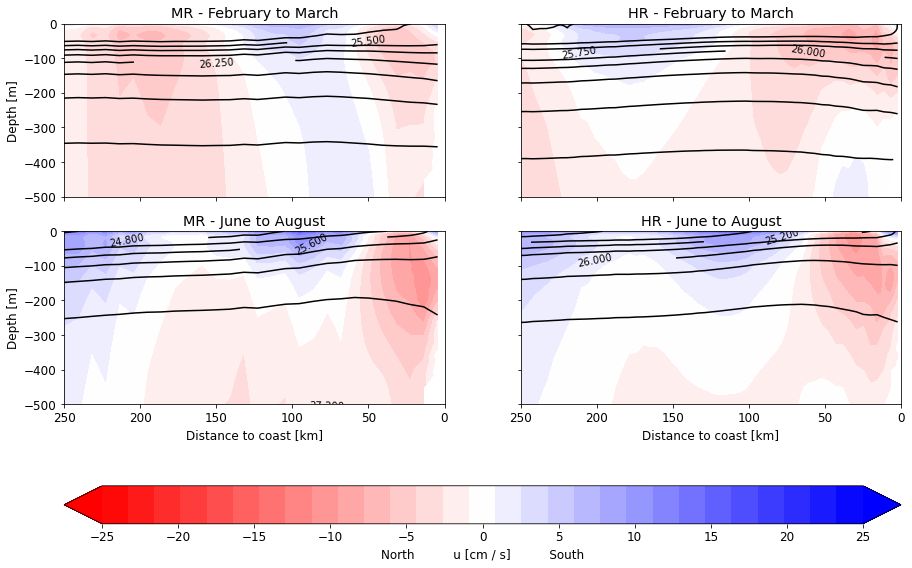

In [16]:
plot_precalculated_comparison(res, captions=['February to March', 'June to August'], path='figures/result_undercurrent.pdf')